In [1]:
# Cell 1
# Import needed packages
import pyodbc

print ( 'All Drivers are: ')
for drivers in pyodbc.drivers(): 
    print ( drivers )


# to connect we need two things:
#   server name: read from sql server
#   database name: we use URL Dashboard database that we defined

server = 'DESKTOP-696L0M6'
database = 'URLDashboard'

# define connection string
conn_str = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server}; \
                         SERVER=' + server + '; \
                         DATABASE=' + database +'; \
                         Trusted_Connection=yes;')


# Create the connection cursor
cursor = conn_str.cursor()

print ( f'Cursor is {cursor}' )

All Drivers are: 
SQL Server
SQL Server Native Client RDA 11.0
ODBC Driver 17 for SQL Server
Cursor is <pyodbc.Cursor object at 0x000002C85440ACB0>


In [2]:
# Cell 2
# Write Schema of our Database


create_link_table = '''
    create table Link ( 
        link_id int primary key identity ( 1, 1 ), 
        short varchar(255) not null,
        long varchar(255) not null
    )
'''

create_create_event_table = '''
    create table Create_Event ( 
        create_id int primary key identity ( 1, 1 ), 
        link_id int not null, 
        create_at datetime not null, 
        foreign key (link_id) references link ( link_id )
    )
'''

create_reference_event_table = '''
    create table Reference_Event ( 
        reference_id int primary key identity ( 1, 1 ), 
        link_id int not null, 
        reference_at datetime not null, 
        foreign key ( link_id ) references link ( link_id )
    )
'''

# Execute the sql statement to create tables
cursor.execute(create_link_table)
cursor.execute(create_create_event_table)
cursor.execute(create_reference_event_table)

# Commit the changes and close the cursor
cursor.commit()
cursor.close()

In [3]:
# Cell 3
# open the cursor
cursor = conn_str.cursor()

# Write function select * from 

def select_all(command):

    print (f'The result of {command} is:')
    
    cursor.execute(command)
    records = cursor.fetchall()
    for record in records: 
        print ( record )

select_all('select * from Link')
select_all('select * from Create_Event')
select_all('select * from Reference_Event')

The result of select * from Link is:
The result of select * from Create_Event is:
The result of select * from Reference_Event is:


In [4]:
# Cell 4
# Import needed packages
import random
import string
from datetime import datetime

In [5]:
# Cell 5
def short_generator():
    # Generate a random strong of length 6 consisting of lowercase and digits
    characters = string.ascii_lowercase + string.digits
    return ''.join(random.choice(characters) for _ in range(6) )

short_generator()

'd3s89e'

In [6]:
# Cell 6
# Write a trigger for insert on create_event after insert on Link table
# Using Trigger
insert_trigger = '''
    create trigger insert_trigger 
    on Link
    after insert
    as 
    begin
        insert into Create_Event ( link_id, create_at )
        select link_id, getdate()
        from inserted
    end
'''

cursor.execute(insert_trigger)

In [7]:
# Cell 7
def insertion(cursor, long_url): 

    # Check if the url already exists or not
    checker = 'select * from Link where long = ?'
    cursor.execute(checker, long_url)
    existing_link = cursor.fetchone()

    if existing_link:
        # If alread exists
        return existing_link.short
    
    else: 
        # Generate a short
        short = short_generator()

    link_insertion = 'insert into Link (short, long) values ( ? ,? )'
    cursor.execute(link_insertion, short, long_url)

    cursor.commit()

    return short

In [8]:
# Cell 8
# Insert some rows and check the status
insertion(cursor, 'https://www.google.com')

'5j0jv3'

In [9]:
# Cell 9
select_all('select * from Link')
select_all('select * from Create_Event')
select_all('select * from Reference_Event')

The result of select * from Link is:
(1, '5j0jv3', 'https://www.google.com')
The result of select * from Create_Event is:
(1, 1, datetime.datetime(2023, 6, 20, 19, 15, 29, 370000))
The result of select * from Reference_Event is:


In [10]:
# Cell 10
# No change affect
insertion(cursor, 'https://www.google.com')

'5j0jv3'

In [11]:
# Cell 11
select_all('select * from Link')
select_all('select * from Create_Event')
select_all('select * from Reference_Event')

The result of select * from Link is:
(1, '5j0jv3', 'https://www.google.com')
The result of select * from Create_Event is:
(1, 1, datetime.datetime(2023, 6, 20, 19, 15, 29, 370000))
The result of select * from Reference_Event is:


In [12]:
# Cell 12
# Give the short form and get the Long form of link

def reference(cursor, short):
    
    # Checker query
    # check is this short link exists or not
    select_query = 'select link_id, long from Link where short = ?'
    cursor.execute(select_query, short)
    result = cursor.fetchone()

    if result:
        # Insert the reference event into the Reference_Event table
        link_id = result.link_id
        insert_query = 'insert into Reference_Event(link_id, reference_at) values (?, getdate())'
        cursor.execute(insert_query, link_id)
        cursor.commit()
        # Return the corresponding URL
        return result.long
    else:
        # Throw an error if short does not exist
        raise ValueError('Short form does not exist')
    

In [13]:
# Cell 13
reference(cursor, '5j0jv3')

'https://www.google.com'

In [14]:
# Cell 14
reference(cursor, '112233')

ValueError: Short form does not exist

In [15]:
# Cell 15

# Get FK names
get_FK_names = '''
SELECT name FROM sys.foreign_keys 
WHERE referenced_object_id = OBJECT_ID('Link')
'''
cursor.execute(get_FK_names)
FK_names = cursor.fetchall()
FK_names = [row[0].replace("(", "").replace(")", "").replace(",", "") for row in FK_names]


# Alter table Create_Event ON DELETE CASCADE
# For Deleteing from just one table instead of two
alter_cascade_on_create_event = f'''
    alter table Create_Event 
    drop constraint {FK_names[0]}

    alter table Create_Event
    add constraint FK_Create_Event
    foreign key (link_id)
    references link(link_id)
    on delete cascade
'''

alter_cascade_on_reference_event = f'''
    alter table Reference_Event 
    drop constraint {FK_names[1]}

    alter table Reference_Event
    add constraint FK_Reference_Event
    foreign key (link_id)
    references link(link_id)
    on delete cascade
'''

cursor.execute(alter_cascade_on_create_event)
cursor.execute(alter_cascade_on_reference_event)
cursor.commit()


In [17]:
# Cell 16

# Remove Expired Links from link table
# duration = 1 hour
# You can change duration based on what you want
# Using Procedure

delete_expired_links_query = '''
    create procedure DeleteExpiredLinks
    as
    begin
        delete from Link
        where link_id in (
            select link_id
            from create_event
            where datediff(day, create_at, getdate()) > 7
            --- where datediff(hour, create_at, getdate()) < 1
        )
    end
'''

cursor.execute(delete_expired_links_query)
cursor.commit()

In [18]:
# Cell 17

select_all('select * from Link')
select_all('select * from Create_Event')
select_all('select * from Reference_Event')

The result of select * from Link is:
(1, '5j0jv3', 'https://www.google.com')
The result of select * from Create_Event is:
(1, 1, datetime.datetime(2023, 6, 20, 19, 15, 29, 370000))
The result of select * from Reference_Event is:
(1, 1, datetime.datetime(2023, 6, 20, 19, 16, 39, 923000))


In [19]:
# Cell 18

insertion(cursor, 'https://github.io')

'xf31ta'

In [20]:
# Cell 19

insertion(cursor, 'https://youtube.com')
insertion(cursor, 'https://aparat.ir')
insertion(cursor, 'https://youtube.music.com')
insertion(cursor, 'https://spotify.com')
insertion(cursor, 'https://w3school.com')
insertion(cursor, 'https://linkedin.com')

'2dv8jw'

In [21]:
# Cell 20

select_all('select * from Link')
select_all('select * from Create_Event')
select_all('select * from Reference_Event')

The result of select * from Link is:
(1, '5j0jv3', 'https://www.google.com')
(2, 'xf31ta', 'https://github.io')
(3, 'vtlafj', 'https://youtube.com')
(4, '41ci0f', 'https://aparat.ir')
(5, '5bn258', 'https://youtube.music.com')
(6, 's2awhm', 'https://spotify.com')
(7, '5bw6ms', 'https://w3school.com')
(8, '2dv8jw', 'https://linkedin.com')
The result of select * from Create_Event is:
(1, 1, datetime.datetime(2023, 6, 20, 19, 15, 29, 370000))
(2, 2, datetime.datetime(2023, 6, 20, 19, 18, 57, 837000))
(3, 3, datetime.datetime(2023, 6, 20, 19, 18, 59, 937000))
(4, 4, datetime.datetime(2023, 6, 20, 19, 18, 59, 940000))
(5, 5, datetime.datetime(2023, 6, 20, 19, 18, 59, 947000))
(6, 6, datetime.datetime(2023, 6, 20, 19, 18, 59, 950000))
(7, 7, datetime.datetime(2023, 6, 20, 19, 18, 59, 953000))
(8, 8, datetime.datetime(2023, 6, 20, 19, 18, 59, 953000))
The result of select * from Reference_Event is:
(1, 1, datetime.datetime(2023, 6, 20, 19, 16, 39, 923000))


In [22]:
# Cell 21
# Reference multiple times randomly

cursor.execute('select short from Link')
short_links = [row.short for row in cursor.fetchall()]

for _ in range(100):
    short_link = random.choice(short_links)
    reference(cursor, short_link)

In [23]:
# Cell 22

select_all('select * from Link')
select_all('select * from Create_Event')
select_all('select * from Reference_Event')

The result of select * from Link is:
(1, '5j0jv3', 'https://www.google.com')
(2, 'xf31ta', 'https://github.io')
(3, 'vtlafj', 'https://youtube.com')
(4, '41ci0f', 'https://aparat.ir')
(5, '5bn258', 'https://youtube.music.com')
(6, 's2awhm', 'https://spotify.com')
(7, '5bw6ms', 'https://w3school.com')
(8, '2dv8jw', 'https://linkedin.com')
The result of select * from Create_Event is:
(1, 1, datetime.datetime(2023, 6, 20, 19, 15, 29, 370000))
(2, 2, datetime.datetime(2023, 6, 20, 19, 18, 57, 837000))
(3, 3, datetime.datetime(2023, 6, 20, 19, 18, 59, 937000))
(4, 4, datetime.datetime(2023, 6, 20, 19, 18, 59, 940000))
(5, 5, datetime.datetime(2023, 6, 20, 19, 18, 59, 947000))
(6, 6, datetime.datetime(2023, 6, 20, 19, 18, 59, 950000))
(7, 7, datetime.datetime(2023, 6, 20, 19, 18, 59, 953000))
(8, 8, datetime.datetime(2023, 6, 20, 19, 18, 59, 953000))
The result of select * from Reference_Event is:
(1, 1, datetime.datetime(2023, 6, 20, 19, 16, 39, 923000))
(2, 7, datetime.datetime(2023, 6, 20

In [24]:
# Cell 23
# Import needed libraries
import pandas as pd 
import matplotlib.pyplot as plt

C:\Users\user\AppData\Local\Temp\ipykernel_8404\2357132695.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  create_count_data = pd.read_sql_query(create_count_query, conn_str)


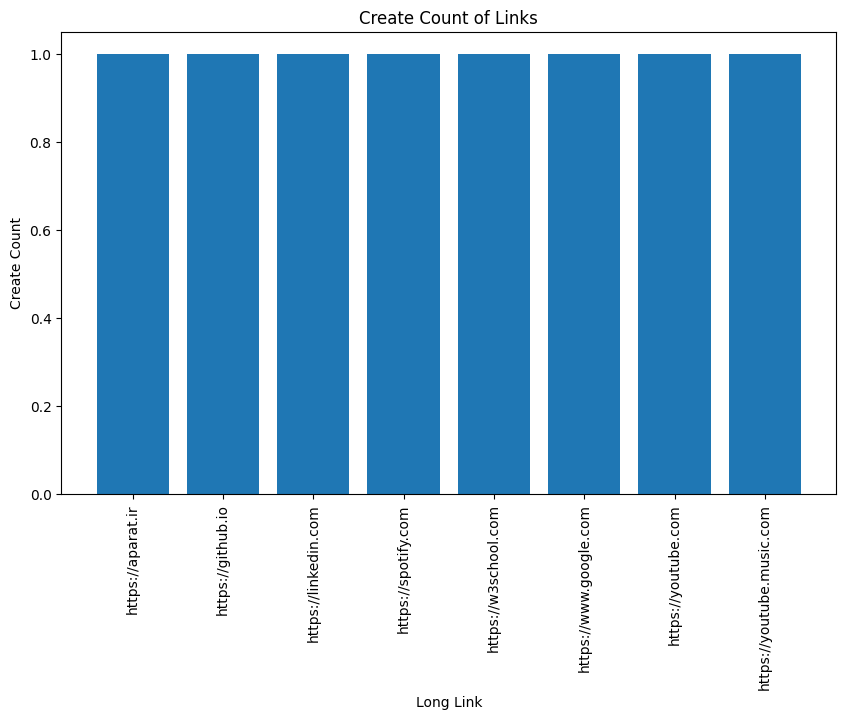

In [25]:
# Cell 24
# Create Count Query for Create_Event
create_count_query = '''
    select long, count(*) as create_count
    from Create_Event
    inner join Link on Create_Event.link_id = Link.link_id
    where datediff(day, Create_Event.create_at, getdate()) < 1
    group by long
'''

create_count_data = pd.read_sql_query(create_count_query, conn_str)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(create_count_data['long'], create_count_data['create_count'])
plt.xlabel('Long Link')
plt.ylabel('Create Count')
plt.title('Create Count of Links')
plt.xticks(rotation=90)
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_8404\3342189765.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  reference_count_data = pd.read_sql_query(reference_count_query, conn_str)


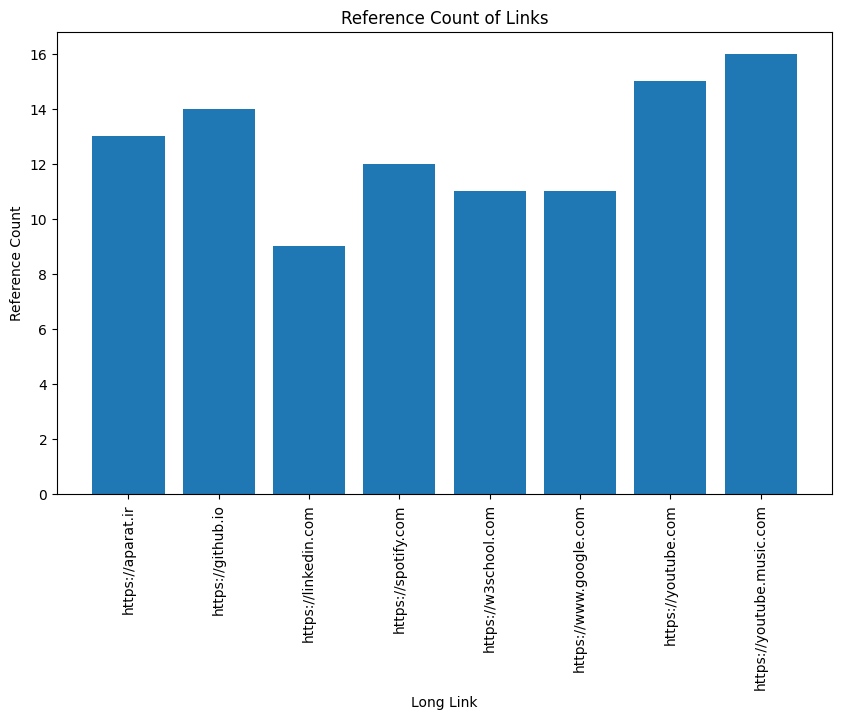

In [26]:
# Cell 25
# Create Count Query for Reference_Event
reference_count_query = '''
    select long, count(*) as reference_count
    from Reference_Event
    inner join Link on Reference_Event.link_id = Link.link_id
    where datediff(day, Reference_Event.reference_at, getdate()) < 1
    group by long
'''

reference_count_data = pd.read_sql_query(reference_count_query, conn_str)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(reference_count_data['long'], reference_count_data['reference_count'])
plt.xlabel('Long Link')
plt.ylabel('Reference Count')
plt.title('Reference Count of Links')
plt.xticks(rotation=90)
plt.show()

In [27]:
# Cell 26
# Top 3 Reference Link
top_3_links = reference_count_data.nlargest(3, 'reference_count')
print(top_3_links)

                        long  reference_count
7  https://youtube.music.com               16
6        https://youtube.com               15
1          https://github.io               14


In [28]:
# Cell 27

# Show all references
# with count reference
# and with remaining days

final_query = '''
    select Link.long, count(*) 
    as 
    reference_count,
    datediff(day, getdate(), dateadd(day, 7, Create_Event.create_at)) as days_remaining
    from Reference_Event
    inner join Link on Reference_Event.link_id = Link.link_id
    inner join Create_Event on Reference_Event.link_id = Create_Event.link_id
    group by Link.long, Create_Event.create_at
'''

cursor.execute(final_query)

# Fetch all results
results = cursor.fetchall()

# Display

for result in results:
    long_link = result.long
    reference_count = result.reference_count
    days_remaining = result.days_remaining
    print(f'Long Link: {long_link}, Reference Count: {reference_count}, Days Remaining: {days_remaining}')


Long Link: https://www.google.com, Reference Count: 11, Days Remaining: 7
Long Link: https://github.io, Reference Count: 14, Days Remaining: 7
Long Link: https://youtube.com, Reference Count: 15, Days Remaining: 7
Long Link: https://aparat.ir, Reference Count: 13, Days Remaining: 7
Long Link: https://youtube.music.com, Reference Count: 16, Days Remaining: 7
Long Link: https://spotify.com, Reference Count: 12, Days Remaining: 7
Long Link: https://linkedin.com, Reference Count: 9, Days Remaining: 7
Long Link: https://w3school.com, Reference Count: 11, Days Remaining: 7


In [29]:
# Don't forget to commit and close
# Cell 28

cursor.commit()
cursor.close

<function Cursor.close>